In [44]:
import typing as ty
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix

Load the scenes and the predictions

In [106]:
repo_root = Path("..")

results_dir = (
    repo_root / "exp/scannet/semseg-pt-v3m1-1-ppt-extreme/result"
)
scenes_dir = (
    repo_root / "data/scannet/val"
)

predictions = {
    path.stem.rstrip("_pred"): np.load(path) 
    for path in results_dir.glob("*.npy")
}
scenes = {
    path.stem: torch.load(path) 
    for path in scenes_dir.glob("*.pth")
}

Just take the first scene for now

In [100]:
for scene_id, pred in predictions.items():
    points = scenes[scene_id]
    labels = points["semantic_gt20"]
    break

In [101]:
df = pd.DataFrame(dict(pred=pred, gt=labels))

In [107]:
classes = [
    'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door',
    'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain',
    'refridgerator', 'shower curtain', 'toilet', 'sink', 'bathtub',
    'otherfurniture'
]


In [104]:
ds

<xarray.Dataset> Size: 21MB
Dimensions:          (point: 273280, coord_dim: 3, color_dim: 3, normal_dim: 3,
                      classes_scannet: 36)
Coordinates:
  * point            (point) int64 2MB 0 1 2 3 4 ... 273276 273277 273278 273279
  * coord_dim        (coord_dim) <U1 12B 'x' 'y' 'z'
  * color_dim        (color_dim) <U1 12B 'r' 'g' 'b'
  * normal_dim       (normal_dim) <U2 24B 'nx' 'ny' 'nz'
  * classes_scannet  (classes_scannet) <U14 2kB 'wall' 'floor' ... 'otherprop'
Data variables:
    coord            (point, coord_dim) float32 3MB 0.3259 3.135 ... 2.669 1.564
    color            (point, color_dim) float32 3MB 209.0 209.0 ... 71.0 60.0
    normal           (point, normal_dim) float32 3MB -0.3109 0.1277 ... 0.2433
    semantic_gt20    (point) int64 2MB 18 18 18 18 18 18 ... -1 13 13 13 13 13
    semantic_gt200   (point) int64 2MB 36 36 36 36 36 36 ... -1 18 18 18 18 18
    instance_gt      (point) int64 2MB 25 25 25 25 25 25 ... -1 10 10 10 10 10
    pred             (point) int64 2MB 18 18 18 18 18 18 ... 13 13 13 13 13 13
Attributes:
    scene_id:  scene0435_01

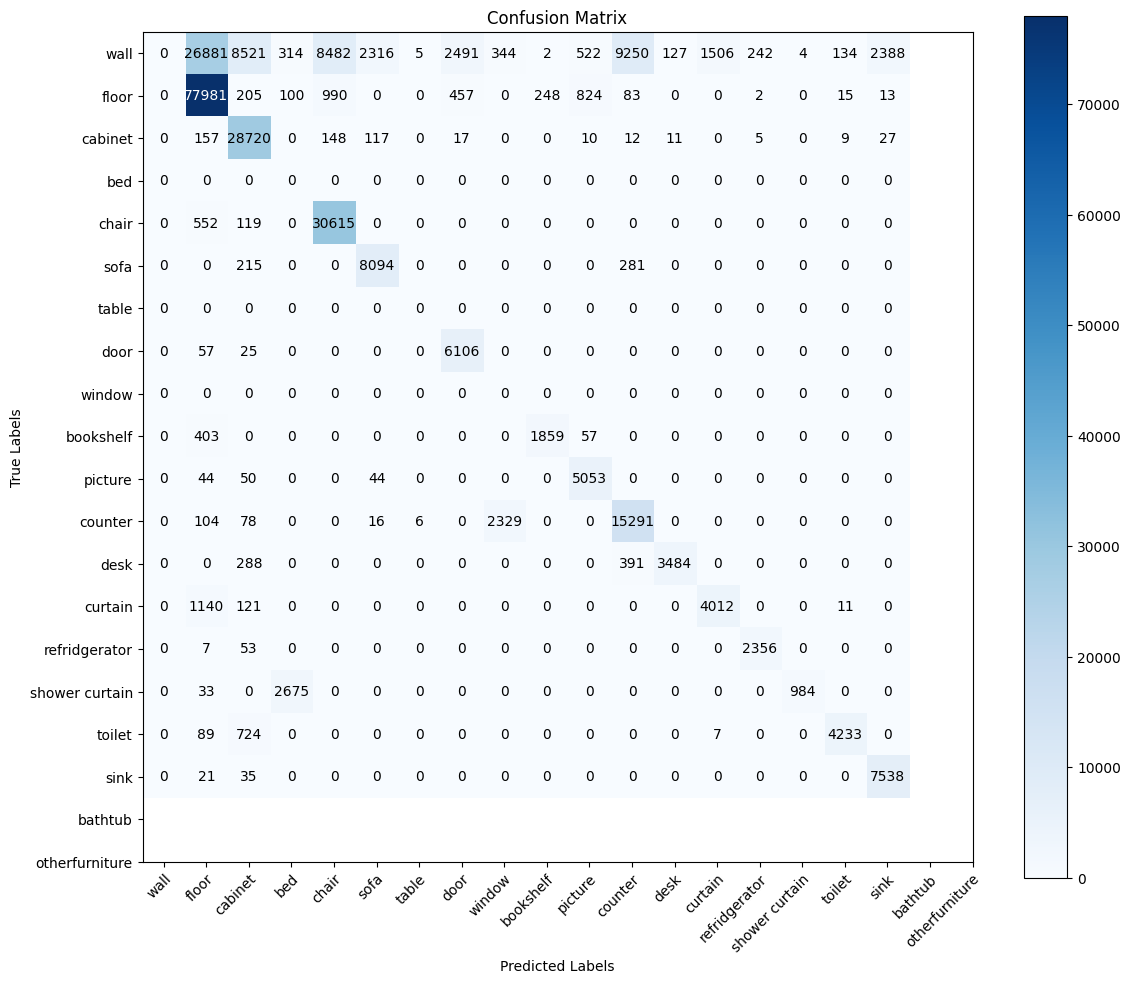

In [110]:
# Extract the predicted and ground truth labels from the DataFrame
y_pred = df['pred']
y_true = df['gt']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust the figure size as needed

# Plot the confusion matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add a color bar
cbar = ax.figure.colorbar(im, ax=ax)

# Define the class names
#classes = class_name
classes = [
    'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door',
    'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain',
    'refridgerator', 'shower curtain', 'toilet', 'sink', 'bathtub',
    'otherfurniture'
]

# Set the tick labels and positions
ax.set(xticks=np.arange(len(classes)),
       yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted Labels',
       ylabel='True Labels')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# Set the title
ax.set_title("Confusion Matrix")

# Adjust the layout and display the plot
fig.tight_layout()
plt.show()

In [111]:
def create_pc_dataset(pc_dict: dict[str, ty.Any]) -> xr.Dataset:
    """
    Create an Xarray dataset from a point cloud dictionary.

    Args:
        pc_dict (Dict[str, Any]): A dictionary containing point cloud data with the following keys:
            - 'coord': The point coordinates as a 2D numpy array of shape (num_points, 3).
            - 'color': The point colors as a 2D numpy array of shape (num_points, 3).
            - 'normal': The point normals as a 2D numpy array of shape (num_points, 3).
            - 'semantic_gt20': The semantic labels (20 classes) as a 1D numpy array of shape (num_points,).
            - 'semantic_gt200': The semantic labels (200 classes) as a 1D numpy array of shape (num_points,).
            - 'instance_gt': The instance labels as a 1D numpy array of shape (num_points,).
            - 'scene_id': The scene ID as a string.

    Returns:
        xr.Dataset: An Xarray dataset representing the point cloud data.

    Raises:
        KeyError: If any of the required keys are missing from the input dictionary.
        ValueError: If the input arrays have inconsistent shapes or if the 'scene_id' is not a string.

    Example:
        pc_dict = {
            'coord': np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]]),
            'color': np.array([[255, 0, 0], [0, 255, 0]]),
            'normal': np.array([[0.0, 0.0, 1.0], [0.0, 1.0, 0.0]]),
            'semantic_gt20': np.array([1, 2]),
            'semantic_gt200': np.array([10, 20]),
            'instance_gt': np.array([1, 1]),
            'scene_id': 'scene_0001'
        }
        pc_dataset = create_pc_dataset(pc_dict)
    """
    # Check if all required keys are present in the input dictionary
    required_keys = [
        'coord', 'color', 'normal', 'semantic_gt20', 'semantic_gt200', 
        'instance_gt', 'scene_id'
    ]
    for key in required_keys:
        if key not in pc_dict:
            raise KeyError(f"Missing required key '{key}' in the input dict")

    # Check if the input arrays have consistent shapes
    num_points = len(pc_dict['coord'])
    for key in ['color', 'normal']:
        if pc_dict[key].shape != (num_points, 3):
            raise ValueError(f"Array '{key}' has an inconsistent shape. Expected ({num_points}, 3).")
    for key in ['semantic_gt20', 'semantic_gt200', 'instance_gt']:
        if pc_dict[key].shape != (num_points,):
            raise ValueError(f"Array '{key}' has an inconsistent shape. Expected ({num_points},).")

    # Create an Xarray dataset from the point cloud dictionary
    pc_dataset = xr.Dataset(
        data_vars=dict(
            coord=(['point', 'coord_dim'], pc_dict['coord']),
            color=(['point', 'color_dim'], pc_dict['color']),
            normal=(['point', 'normal_dim'], pc_dict['normal']),
            semantic_gt20=(['point'], pc_dict['semantic_gt20']),
            semantic_gt200=(['point'], pc_dict['semantic_gt200']),
            instance_gt=(['point'], pc_dict['instance_gt'])
        ),
        coords=dict(
            point=np.arange(num_points),
            coord_dim=['x', 'y', 'z'],
            color_dim=['r', 'g', 'b'],
            normal_dim=['nx', 'ny', 'nz']
        ),
        attrs=dict(scene_id=pc_dict['scene_id'])
    )

    return pc_dataset

In [112]:
ds = create_pc_dataset(points)
ds = ds.assign_coords(classes_scannet=xr.DataArray(np.array(classes), dims=["classes_scannet"]))
ds["pred"] =(("point",), pred)

In [121]:
df = ds[["coord", "color", "semantic_gt20", "pred"]].to_dataframe()

In [ ]:
df.unstack(level=[0,1,2])